In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

### Importing the training set and saving it as train_df

In [2]:
train_df = pd.read_csv('train.csv', index_col= 0)
train_df.drop("keyword", axis= 1, inplace = True) #Dropping keyword because I want to the model to pick up on keywords
train_df

,location,text,target
id,,,
1,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
10869,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


### Importing test set just like the training set

In [3]:
test_df = pd.read_csv('test.csv', index_col= 0)
test_df.drop("keyword", axis= 1, inplace = True) #Dropping keyword because I want to the model to pick up on keywords
test_df

,location,text
id,,
0,NaN,Just happened a terrible car crash
2,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10865,NaN,Storm in RI worse than last hurricane. My city...
10868,NaN,Green Line derailment in Chicago http://t.co/U...


# Doing my own independent analysis

### Creating another matrix for the words instead of CountVectorizer

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Previously we were using countvectorizer which weights all words the same. Instead we'll use TF-IDF to determine how relevant certain terms are. 
#This should make common words like "a" and "the" less important and improve our model. We'll also use min_df = 2.
#This is so we only consider words that show up more than once. This should help reduce the "noise"

tfidf_vectorizer = TfidfVectorizer(min_df = 2)

# Using fit_transform to "train" the tokenizer on our training set
train_vectors = tfidf_vectorizer.fit_transform(train_df["text"])

# Same as before
test_vectors = tfidf_vectorizer.transform(test_df["text"])


#We go from over 20,000 tokens being considered down to only 6,500.
#There's still 7613 rows of data (each row corresponds to a tweet)
train_vectors

<7613x6594 sparse matrix of type '<class 'numpy.float64'>'
	with 96454 stored elements in Compressed Sparse Row format>

### Applying LSA to our new matrix
Now that we have a matrix with fewer words we'll apply a second trick: LSA (Latent Semantic Analysis)
Essentially we're applying SVD (Singular Value Decomposition) to extract the most important information in the form of uncorrelated vectors.

We do this because the dimensionality is still high and we might get better results by essentially ignoring noisy components of the word-matrix.

In [5]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

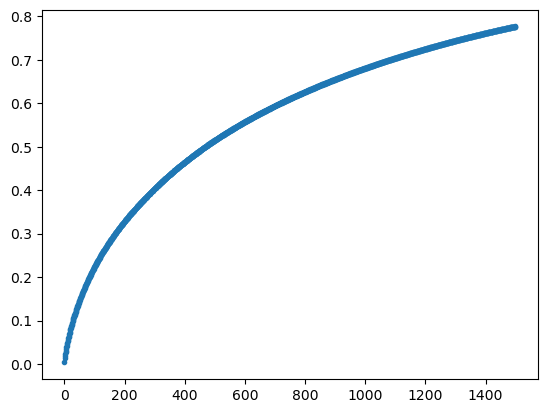

In [6]:
from sklearn.decomposition import TruncatedSVD

comp_used = 1500 #With just 1500 out of 6500+ possible components used we can explain 78% of the variance.
#With 1000 components we can explain 68% of the variance

svd = TruncatedSVD(n_components = comp_used, random_state = 1) #Initializing the SVD settings. We intend to keep comp_used components

svd.fit(train_vectors) #Using the SVD settings from before to fit our matrix into the SVD model. We can then use transform to "apply" it to other matrices
#Not 100% sure how it works but I believe when using transform it calculates the new U times singular value matrix BUT uses the same V. 

import matplotlib.pyplot as plt
%matplotlib inline

c = Cumulative(svd.explained_variance_)
plt.plot(range(len(svd.explained_variance_)), c, '.') #A plot of variance explained vs number of components used


### Using a simple neural network to predict classification with LSA

In [8]:
import torch
from torch import nn
from torcheval.metrics.functional import multiclass_f1_score

dtype = torch.float
device = torch.device("cuda:0")

learning_rate = 1e-6

In [206]:
X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_df["target"].values, test_size= 0.2, random_state=42)

X_train = torch.tensor(svd.transform(X_train), device = device, dtype = dtype, requires_grad = True)
y_train = torch.tensor(y_train, device = device, dtype = dtype, requires_grad = True)


X_test = torch.tensor(svd.transform(X_test), device = device, dtype = dtype, requires_grad = False)
y_test = torch.tensor(y_test, device = device, dtype = dtype, requires_grad = False)

In [228]:
model = nn.Sequential(
    nn.Linear(1500, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50,1),
    nn.Sigmoid()
)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
loss_fn = torch.nn.MSELoss()

rs = model_selection.ShuffleSplit(n_splits=100,test_size= 0.1, random_state = 3)

iter_list = [0]*100

for i,(train_index,test_index) in enumerate(rs.split(X_train)):
    iter_list[i] = train_index

ep = 500
l = [0]*ep
f = [0]*ep


for i in range(ep):
    t = i%100
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_train[iter_list[t]]).squeeze()

    # Compute and print loss
    loss = loss_fn(y_pred,y_train[iter_list[t]])#multiclass_f1_score(y_pred, y)
    if i % 25 == 0:
        print(i, loss.item())
 
    x_temp = model(X_test).squeeze().cpu().detach().numpy().round()
    y_temp = y_test.cpu().detach().numpy().round()
    f[i] = metrics.f1_score(x_temp, y_temp)
        
    # Zero gradients, perform a backward pass, and update the weights.
    l[i] = loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.24622556567192078
25 0.24556560814380646
50 0.2452436089515686
75 0.24470344185829163
100 0.24475699663162231
125 0.2451639026403427
150 0.24486196041107178
175 0.24417416751384735
200 0.24399836361408234
225 0.244033083319664
250 0.24311916530132294
275 0.2413799911737442
300 0.23925815522670746
325 0.2353847175836563
350 0.22660531103610992
375 0.21010425686836243
400 0.18629693984985352
425 0.1622619330883026
450 0.14261122047901154
475 0.1283063143491745


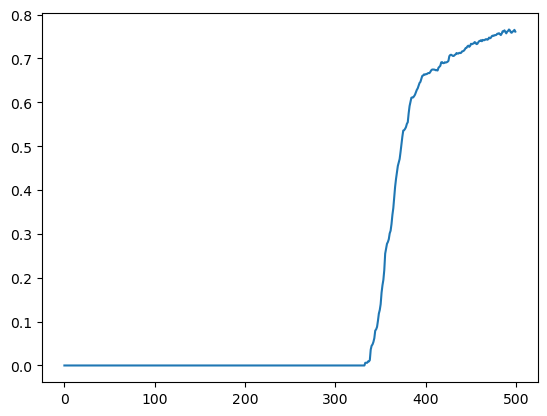

In [229]:
plt.plot(f) #Inverse F1 score where 1 is bad and 0 is good.

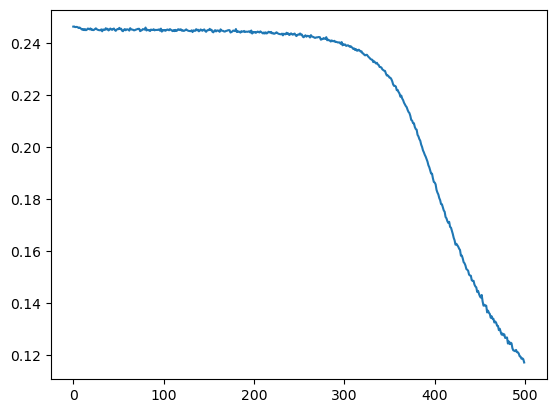

In [230]:
plt.plot(l)

### Training the model but with all the data now

In [10]:
model = nn.Sequential(
    nn.Linear(1500, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50,1),
    nn.Sigmoid()
)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
loss_fn = torch.nn.MSELoss()

rs = model_selection.ShuffleSplit(n_splits=100,test_size= 0.1, random_state = 3)

iter_list = [0]*100

for i,(train_index,test_index) in enumerate(rs.split(train_vectors)):
    iter_list[i] = train_index

ep = 500
l = [0]*ep

X_train = torch.tensor(svd.transform(train_vectors), device = device, dtype = dtype, requires_grad = False)
y_train = torch.tensor(train_df["target"].values, device = device, dtype = dtype, requires_grad = False)

for i in range(ep):
    t = i%100
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_train[iter_list[t]]).squeeze()

    # Compute and print loss
    loss = loss_fn(y_pred,y_train[iter_list[t]])#multiclass_f1_score(y_pred, y)
    if i % 25 == 0:
        print(i, loss.item()) 
        
    # Zero gradients, perform a backward pass, and update the weights.
    l[i] = loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.25042223930358887
25 0.24561807513237
50 0.24476613104343414
75 0.24470598995685577
100 0.24451573193073273
125 0.24475935101509094
150 0.24412518739700317
175 0.2437926083803177
200 0.24310654401779175
225 0.24249407649040222
250 0.2403690069913864
275 0.23718301951885223
300 0.23101116716861725
325 0.21945205330848694
350 0.19913937151432037
375 0.17512258887290955
400 0.1544673889875412
425 0.13760900497436523
450 0.1264604926109314
475 0.11794887483119965


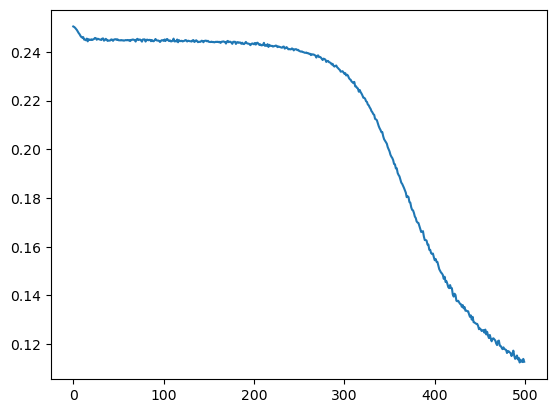

In [11]:
plt.plot(l)

In [38]:
X_test = torch.tensor(svd.transform(test_vectors), device = device, dtype = dtype, requires_grad = False)
Y_test = model(X_test).squeeze()

In [45]:
import numpy

In [46]:
y_df = pd.DataFrame(numpy.rint(Y_test.cpu().detach().numpy()), columns = ["target"]).set_index(test_df.index)

In [49]:
y_df = y_df.astype({'target':'int'})

In [51]:
y_df.to_csv("submission_nn.csv")